In [106]:
import pandas as pd
from matplotlib import pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
from sklearn.preprocessing import LabelEncoder

# Data preparing

In [107]:
data = pd.read_csv('./data/data.csv')
data

,Area,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item,Item Price Per Tonne,Overall Inflation Rate
0,Albania,2012,2.404087,12319.779604,-4.430218,Apples,369.7,3.2
1,Albania,2012,2.404087,12319.779604,-4.430218,Apricots,489.9,3.2
2,Albania,2012,2.404087,12319.779604,-4.430218,Barley,316.1,3.2
3,Albania,2012,2.404087,12319.779604,-4.430218,"Beans, dry",1562.2,3.2
4,Albania,2012,2.404087,12319.779604,-4.430218,Cabbages,203.4,3.2
...,...,...,...,...,...,...,...,...
15644,Switzerland,2022,1.661019,818426.550206,0.616880,Tomatoes,3407.9,2.7
15645,Switzerland,2022,1.661019,818426.550206,0.616880,Triticale,362.4,2.7
15646,Switzerland,2022,1.661019,818426.550206,0.616880,Unmanufactured tobacco,16495.0,2.7
15647,Switzerland,2022,1.661019,818426.550206,0.616880,"Walnuts, in shell",3498.0,2.7


In [108]:
data['Difference of inflation'] = data['Food Inflation Rate'] - data['Overall Inflation Rate']

In [109]:
mean_value = data['Difference of inflation'].mean()
std_dev = data['Difference of inflation'].std()
mean_value, std_dev

(0.6515898678563061, 1.8824104304769327)

In [110]:
threshold = mean_value + std_dev

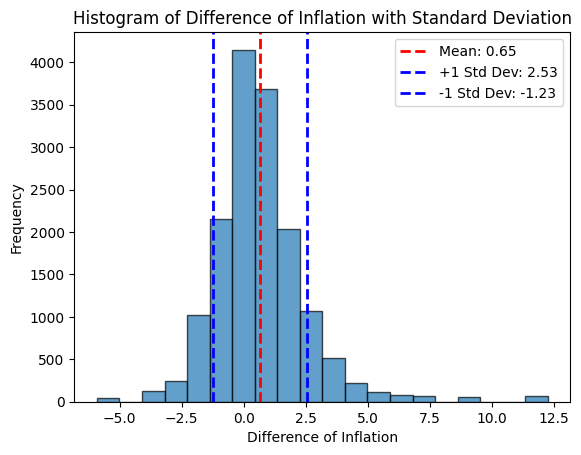

In [111]:
plt.hist(data['Difference of inflation'], bins=20, edgecolor='black', alpha=0.7)

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mean_value + std_dev, color='blue', linestyle='dashed', linewidth=2,
            label=f'+1 Std Dev: {mean_value + std_dev:.2f}')
plt.axvline(mean_value - std_dev, color='blue', linestyle='dashed', linewidth=2,
            label=f'-1 Std Dev: {mean_value - std_dev:.2f}')

plt.title('Histogram of Difference of Inflation with Standard Deviation')
plt.xlabel('Difference of Inflation')
plt.ylabel('Frequency')

plt.legend()

plt.show()

In [112]:
data['label'] = data['Difference of inflation'].apply(lambda x: 1 if x > threshold else 0)

In [113]:
data.head()

,Area,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item,Item Price Per Tonne,Overall Inflation Rate,Difference of inflation,label
0,Albania,2012,2.404087,12319.779604,-4.430218,Apples,369.7,3.2,-0.795913,0
1,Albania,2012,2.404087,12319.779604,-4.430218,Apricots,489.9,3.2,-0.795913,0
2,Albania,2012,2.404087,12319.779604,-4.430218,Barley,316.1,3.2,-0.795913,0
3,Albania,2012,2.404087,12319.779604,-4.430218,"Beans, dry",1562.2,3.2,-0.795913,0
4,Albania,2012,2.404087,12319.779604,-4.430218,Cabbages,203.4,3.2,-0.795913,0


In [114]:
numerical_columns=['Food Inflation Rate', 'Raw GDP', 'GDP Growth Rate','Item Price Per Tonne', 'Overall Inflation Rate', 'Difference of inflation']

Uncomment this code for encoding with binary encoder

In [115]:
# binary_encoder = ce.BinaryEncoder(cols=['Item', 'Area'])
# data = binary_encoder.fit_transform(data)

Uncomment this code for encoding with label encoder

In [116]:
label_encoder = LabelEncoder()
data['Item'] = label_encoder.fit_transform(data['Item'])
data['Area'] = label_encoder.fit_transform(data['Area'])
numerical_columns.append('Item')
numerical_columns.append('Area')

In [117]:
scaler = RobustScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [118]:
data.head()

,Area,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item,Item Price Per Tonne,Overall Inflation Rate,Difference of inflation,label
0,-0.941176,2012,0.160705,-0.422628,-0.784202,-1.000000,-0.299190,0.708333,-0.704691,0
1,-0.941176,2012,0.160705,-0.422628,-0.784202,-0.986667,-0.229156,0.708333,-0.704691,0
2,-0.941176,2012,0.160705,-0.422628,-0.784202,-0.906667,-0.330420,0.708333,-0.704691,0
3,-0.941176,2012,0.160705,-0.422628,-0.784202,-0.893333,0.395618,0.708333,-0.704691,0
4,-0.941176,2012,0.160705,-0.422628,-0.784202,-0.813333,-0.396085,0.708333,-0.704691,0


# Model training and evaluation

Remove 'Difference of inflation' if needed

In [119]:
X, Y = data.drop(columns=['label', 'Difference of inflation']), data['label']

classifier = RandomForestClassifier(
    n_estimators=10,
    max_depth=2,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2889
           1       0.48      0.78      0.60       241

    accuracy                           0.92      3130
   macro avg       0.73      0.86      0.78      3130
weighted avg       0.94      0.92      0.93      3130



In [120]:
y_test.value_counts()

label
0    2738
1     392
Name: count, dtype: int64

# SHAP explainability

In [121]:
explainer = shap.Explainer(classifier)
shap_values = explainer.shap_values(x_test)

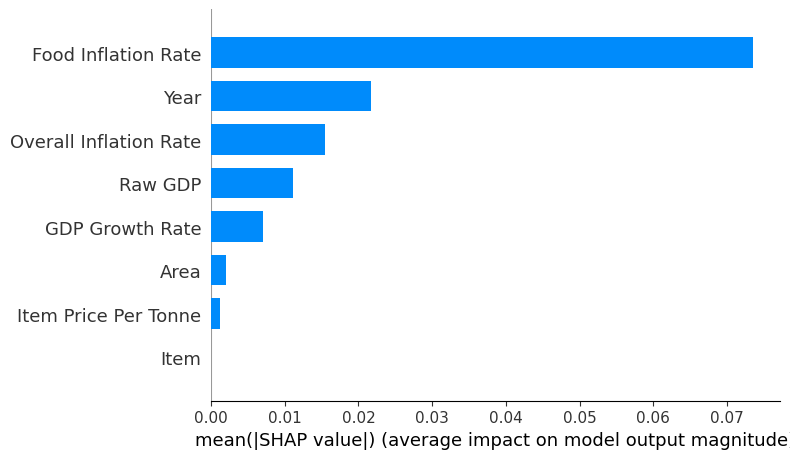

In [122]:
shap.summary_plot(shap_values[:, :, 1], x_test, plot_type="bar")

In [123]:
# background_data = shap.sample(x_train, 10)
# # background_data = shap.kmeans(x_train2, 10)
# explainer = shap.KernelExplainer(classifier.predict_proba, background_data)
# shap_values = explainer.shap_values(x_test)
# shap.force_plot(explainer.expected_value[0], shap_values[..., 0], x_test)